In [1]:
!pip install matplotlib
!pip install machinevision-toolbox-python

!pip install --no-deps rvc3python

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
from IPython.core.display import HTML

import RVC3 as rvc
import sys, os.path
sys.path.append(os.path.join(rvc.__path__[0], 'examples'))

import numpy as np
from scipy import linalg, stats
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from machinevisiontoolbox import Camera
from spatialmath.base import *
from spatialmath import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.0/238.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.9/184.9 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 42.1

In [2]:
# Load two scene images with left (walls_l) and right (walls_r) cameras,
# reducing the resolution of each image by a factor of two (reduce=2) for easier processing.
walls_l = Image.Read("walls-l.png", reduce=2);
walls_r = Image.Read("walls-r.png", reduce=2);

In [3]:
# Computing SIFT descriptors
sf_l = walls_l.SIFT()  # SIFT descriptors (sf_l and sf_r) are computed for each of the loaded images,
                       # allowing to describe and identify key points on the images.
sf_r = walls_r.SIFT()


SIFTFeature features, 18478 points

In [4]:
# Matching Descriptors
matches = sf_l.match(sf_r);  # Matching SIFT descriptors between the left and right images,
                              # resulting in the creation of the matches object containing information about the found correspondences.
matches


2797 matches

In [5]:
# Estimating the Fundamental Matrix
F, resid = matches.estimate(CentralCamera.points2F, confidence=0.99, seed=0)  # Using the RANSAC method,
                                                                   # the fundamental matrix F is estimated for the selected correspondences.
                                                                   # The residual error resid reflects the quality of the estimation.
F, resid


(array([[-5.754e-08, -5.269e-06, 0.002338],
        [4.942e-06, 3.89e-07, -0.03566],
        [-0.001941,  0.03546,        1]]),
 1.7674501802731584)

In [6]:
## Selecting Consistent Points
matches = matches.inliers  # Keep only the inliers
                           # Only the correspondences that are consistent (inliers),
                           # i.e., most likely belonging to the same object in both images, are retained from all found correspondences.
matches


2389 matches, with 2389 (100.0%) inliers

In [7]:
# Determining the focal length
f = walls_l.metadata("FocalLength")


4.15

In [8]:
# Determining the camera model name
name = walls_l.metadata("Model")


'iPhone 5s'

In [9]:
# Initializing the Camera
camera = CentralCamera(name='name', imagesize=walls_l.shape,  # An instance of CentralCamera is created with parameters
                                                            # obtained from the image metadata.
                                                            # The focal length value f is converted from millimeters to meters.
                       f=f/1000, rho=2*1.5e-6)


           Name: name [CentralCamera]
     pixel size: 3e-06 x 3e-06
     image size: 1224 x 1632
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [     612      816]
   focal length: [ 0.00415  0.00415]

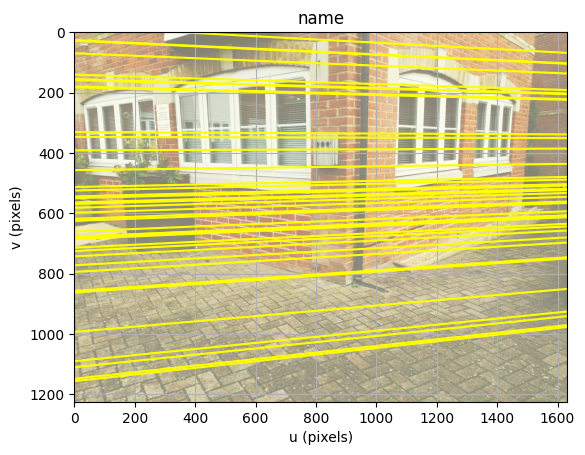

In [10]:
camera.disp(walls_l, alpha=0.5)
camera.plot_epiline(F.T, matches.subset(40).p2, "yellow")
#camera.disp(walls_r, alpha=0.5)
plt.show()

In [11]:
# Assuming the principal point is in the center
# Computing the Essential Matrix and Decomposition
E = camera.E(F)  # The essential matrix E is computed from the fundamental matrix F,


array([[ -0.1101,   -10.08,   -2.762],
       [   9.457,   0.7444,   -44.71],
       [   2.845,    45.03,    1.149]])

In [12]:
# Assuming a point depth of 10 meters based on the assumption and in theory, in this example, the relationship with the focal length
# In fact, there should be a formula determining the depth of field plus delta
T_1_2 = camera.decomposeE(E, [0, 0, 10])  # Then decomposition is performed to determine the relative position
                                           # and orientation of the second camera with respect to the first.


   0.9999    0.00797   0.0125   -0.9764    
  -0.007688  0.9997   -0.02241   0.06693   
  -0.01267   0.02231   0.9997   -0.2054    
   0         0         0         1         


In [13]:
T_1_2.printline(orient="camera")

t = -0.976, 0.0669, -0.205; rpy/yxz = -0.441°, 1.28°, 0.716°


In [14]:
t = T_1_2.t #трансляции t просто отрезаем углы

array([ -0.9764,  0.06693,  -0.2054])

In [15]:
s = 0.3 / t[0]      # Assuming the photos are taken at a distance of 30 cm, we set the scale difference coefficient for the second camera.
                    # In reality, we set the distance between the cameras as an input variable.
                    # With only one camera, a rigid debugging step is desirable in each plane while maintaining the central focus point.


-0.30725548754584636

In [16]:
T_1_2.t = s * t # scaled translation
T_1_2.printline(orient="camera")

t = 0.3, -0.0206, 0.0631; rpy/yxz = -0.441°, 1.28°, 0.716°


In [17]:
ray1 = camera.ray(matches[0].p1)  # Here, ray1 and ray2 represent rays projected from the camera
                                  # in the direction of the first consistent pair of points (matches[0].p1
                                  # on the first image and matches[0].p2 on the second, respectively).
                                  # pose=T_1_2 is applied to the second ray to account for the relative
                                  # position and orientation of the second camera with respect to the first.


{ 0 0 0; 0.45053 -0.43771 1}

In [18]:
# For understanding purposes, not actually needed in the code
# Computing Rays from the Camera
ray2 = camera.ray(matches[0].p2, pose=T_1_2)


{ -0.0071757 0.27523 0.12379; 0.3282 -0.43513 0.98647}

In [19]:
# For understanding purposes, not actually needed in the code
# Triangulating 3D Points
P, e = ray1.closest_to_line(ray2)  # The closest_to_line method is used to compute the closest point
                                    # between two rays, ray1 and ray2, representing a triangulation method
                                    # to find the 3D coordinates of the corresponding point P in space.
                                    # e represents the error or distance between the rays at the closest point,
                                    # providing insight into the accuracy of the triangulation.
print(P)
print(e)


[   1.066   -1.036    2.367]
0.0006718430761683649


In [20]:
# Continuing with actual computations
# Triangulating All Consistent Points
ray1 = camera.ray(matches.p1)
ray2 = camera.ray(matches.p2, pose=T_1_2)
len(ray1)


2389

In [21]:
# Continuing with actual computations
# Computing the Closest Point
P, e = ray1.closest_to_line(ray2)
P


array([[   1.066, -0.03681,    1.961, ...,   0.6783,   0.8129,   0.5067],
       [  -1.036,  -0.9984,   -1.468, ...,   0.2345,   0.1173,    0.185],
       [   2.367,    2.098,    3.345, ...,     1.11,    1.479,    1.248]])

In [22]:
# Checking the average temperature throughout the hospital
# Computing Statistical Indicators:
# Mean value of Z coordinates of reconstructed points (z.mean())
z = P[2, :]
z.mean()


2.2336901958654556

In [23]:
# Statistics for e
me = np.median(e)  # Median triangulation error
emax = e.max()  # Maximum error - This fly won't miss the door :)))
print(me)
print(emax)


0.004671581575132002
0.024741940113809688


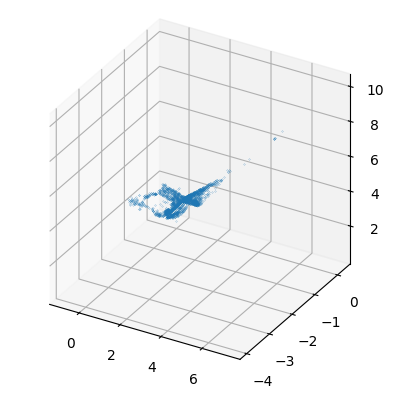

In [24]:
# Displaying the wonderful plot with the collapsed wall, just like in the original book.
plotvol3()
plt.plot(P[0,:], P[1,:], P[2,:], '.', markersize=0.3)


In [25]:
# If there is a library and you want to view it nicely in the correct format, uncomment the line below
#walls_pcd = PointCloud(P)


In [26]:
# Lift the fallen wall
#walls_pcd.transform(SE3.Rx(pi))  # make y-axis upward


In [27]:
# Display the image
#walls_pcd.disp(block=True) # Press H for control


In [28]:
# Clean up by removing outliers
#walls_pcd = walls_pcd.remove_outlier(nb_points=10, radius=0.9)
                          # Removing outliers from the point cloud using the remove_outlier method,
                          # which removes points for which there are fewer than the specified number of nearby points (nb_points)
                          # within a given radius (radius).
                          # This helps clean the point cloud from noise and anomalous points.


In [29]:
# Display the cleaned image
#walls_pcd.disp(block=True) # Press H for control


In [30]:
# Adding Color to the Point Cloud. Uncomment the block below.
#colors = []
#for m in matches:
#    colors.append(walls_l.image[int(m.p1[1]), int(m.p1[0]), :])
#pcd = SE3.Rx(pi) * PointCloud(P, colors=np.array(colors).T)
#pcd.disp(block=True)


In [31]:
p1_reproj = camera.project_point(P[:, 0])  # Reprojecting the first point from the set P onto the images of both cameras
                                          # for analyzing the accuracy of reconstruction and correspondence.


array([[    1235],
       [   210.5]])

In [32]:
p2_reproj = camera.project_point(P[:, 0], pose=T_1_2)  #Вычисление различий между перепроектированными точками и исходными
                                                       #точками согласований.
                                                       #Это позволяет оценить точность восстановления 3D-позиций и качество триангуляции.

array([[    1053],
       [   248.7]])

In [33]:
p2_reproj = camera.project_point(P[:, 0], pose=T_1_2)  # Computing differences between reprojected points and original
                                                       # correspondence points.
                                                       # This allows to assess the accuracy of 3D position reconstruction and the quality of triangulation.


array([[    1053],
       [   248.7]])

In [34]:
(p2_reproj - matches[0].p2).T

array([[-0.06476,   -804.6],
       [   804.9,   0.4298]])

In [35]:
bundle = BundleAdjust(camera)  # An instance of BundleAdjust is created to perform bundle adjustment,
                               # a process that refines 3D point coordinates, camera parameters, and its position
                               # by minimizing projection errors between observed and predicted positions
                               # of points on images. This improves the accuracy of the reconstructed 3D model.


Bundle adjustment problem:  0 views
  0 landmarks
  0 projections
  0 total states
  0 variable states
  0 equations

In [36]:
# Initializing Views for Bundle Adjustment
view0 = bundle.add_view(SE3(), fixed=True)  # Camera 1
                                            # Two "views" are created in the bundle object for bundle adjustment.
                                            # The first view (view0) is fixed (fixed=True), assuming it is the initial camera position
                                            # and it is known precisely.
                                            # The second view (view1) represents the camera position after moving 0.3 meters along the X-axis (SE3.Tx(0.3)).


ViewPoint[view#0, coord=(0, 0, 0, 0, 0, 0)]

In [37]:
view1 = bundle.add_view(SE3.Tx(0.3)) #Камера 2 сдвинутая на 0,3метра

ViewPoint[view#1, coord=(0.3, 0, 0, 0, 0, 0)]

In [38]:
for (Pj, mj) in zip(P[:, ::4].T, matches[::4]):
   landmark = bundle.add_landmark(Pj) # add vertex
   bundle.add_projection(view0, landmark, mj.p1) # add edge
   bundle.add_projection(view1, landmark, mj.p2) # add edge

# The for loop iterates over pairs of points Pj and correspondences mj.
# P[:, ::4].T extracts every fourth point from the P array (presumably an array of points in space),
# using array indexing in Python with slices.
# ":" selects all rows in the P array,
# "::4" selects every fourth column in the selected rows.
# For example, every fourth row, every fourth element: array[::4, ::4]
# matches[::4] does the same for the correspondences (presumably an array of point correspondences in the image).
# "[::4]": This slice selects every fourth element from a one-dimensional array.
# There's no row-wise separation here as the array is one-dimensional.
# zip combines these two lists into pairs.


In [39]:
bundle #Просто обоьражаем

Bundle adjustment problem:  2 views
    1 locked views: [0]
  598 landmarks
  1196 projections
  1806 total states
  1800 variable states
  2392 equations
  landmarks per view: min=598, max=598, avg=598.0
  views per landmark: min=2, max=2, avg=2.0

In [42]:
x = bundle.getstate()  # The current state of adjustment parameters is extracted.

array([       0,        0,        0, ...,   0.5067,    0.185,    1.248])

In [43]:
x.shape  # The shape of the bundle as a vector x is then analyzed.


(1806,)

In [44]:
x[6:12]  # The position of the second camera is located in the second block of 6 elements.


array([     0.3,        0,        0,        0,        0,        0])

In [45]:
x[12:15]  # Translation followed by rotation is stored in this block.


array([   1.066,   -1.036,    2.367])

In [46]:
bundle.errors(x)   # Compute bundle adjustment errors for the current state of parameters,
                   # allowing to evaluate the quality of the current model.


1460212.3827897194

In [47]:
#! Ask what it does and where the parameter r comes from - not determined.
#p, A, B = camera.derivatives(t, r, P)
# Where t and r represent the camera position as translation and rotation vectors,
# P is a vector of coordinates of landmark points.
# When the camera is shifted by d or the point is shifted,
# d has an equivalent effect on the image, therefore,
# Bj is a negative value of the first three columns of Aj.
# Now everything is ready to solve the bundle adjustment problem.


In [48]:
x_new, resid = bundle.optimize(x)  # The optimization process is launched, which attempts to minimize the total projection error
                                   # by correcting model parameters, including camera positions and landmark coordinates.
                                   # x_new contains the optimized parameters,
                                   # and resid contains the residual error after optimization.


Bundle adjustment cost 1.46e+06 -- initial
Bundle adjustment cost 3.42e+03 (solved in 3.13 sec)
Bundle adjustment cost 293 (solved in 3.54 sec)
Bundle adjustment cost 289 (solved in 3.59 sec)
Bundle adjustment cost 289 (solved in 3.08 sec)
Bundle adjustment cost 289 (solved in 3.04 sec)
Bundle adjustment cost 289 (solved in 3.96 sec)

 * 6 iterations in 21.1 seconds
 * Final RMS error is 0.49 pixels


In [51]:
# Applying Optimized Parameters
bundle.setstate(x_new)    # The set_state method applies the optimized state vector x_new
                          # to the bundle adjustment object bundle.
                          # This updates the model parameters, including camera positions
                          # and landmark coordinates, to their optimized values.


In [55]:
# Analysis of the Second View Position
bundle.views[1].pose.printline(orient="camera")  # Information about the position and orientation of the second camera after optimization is printed.
                                                  # This allows to see how the position and orientation of the camera have changed
                                                  # as a result of bundle adjustment.
# Ideally, if the cameras are fixed, the values with T_1_2 should coincide.
# Or have small deviations.
# In reality, conduct an analysis on an additional pair of frames, if not, raise a question about malfunction or continue execution, operator control.


t = 0.365, -0.0302, 0.0852; rpy/yxz = -0.601°, 1.27°, 0.117°


In [56]:
T_1_2.printline(orient="camera")

t = 0.3, -0.0206, 0.0631; rpy/yxz = -0.441°, 1.28°, 0.716°


In [57]:
# Analysis of Landmarks
bundle.landmarks[0].P   # The position of the first landmark is extracted and printed after optimization.
                        # This gives an idea of how optimization has affected the placement of landmarks in 3D space.


array([   1.066,   -1.036,    2.367])

In [60]:
# Evaluation of Errors After Optimization
e = np.sqrt(bundle.getresidual())  # The square root of the sum of squares of residual errors is computed for each observation after optimization.
                                     # This allows to assess how well the optimized model fits the observed data.
e.shape       # The dimensionality of the error array is printed to understand how many observations were considered in the bundle adjustment process.


(2, 598)

In [61]:
# where the element .i; j / represents the reprojection error in pixels for camera i and landmark j.
# The median error for cameras one and two
np.median(e, axis=1)
            # are around a quarter of a pixel


array([  0.3014,    0.295])

In [62]:
# while the maximum errors
# are less than 2 pixels.
np.max(e, axis=1)


array([   2.107,    1.984])

In [63]:
# For analysis, compute Rays from the Camera, output the old one and see what matches { 0 0 0; 0.45053 -0.43771 1}
ray1 = camera.ray(matches[0].p1)


{ 0 0 0; 0.45053 -0.43771 1}

In [64]:
# For analysis, let's take a look
T_1_2

   0.9999    0.00797   0.0125    0.3       
  -0.007688  0.9997   -0.02241  -0.02056   
  -0.01267   0.02231   0.9997    0.06311   
   0         0         0         1         


In [65]:
# Create a variable for the new refined translation.
vcv = bundle.views[1].pose

   0.9999    0.01053   0.002043  0.3654    
  -0.01048   0.9997   -0.02212  -0.03025   
  -0.002276  0.0221    0.9998    0.08515   
   0         0         0         1         


In [66]:
# For analysis, find the closest point between rays with the new translation and compare
# The old one was { -0.0071757 0.27523 0.12379; 0.3282 -0.43513 0.98647}
ray2 = camera.ray(matches[0].p2,  pose=vcv)


{ -0.0071568 0.33477 0.14964; 0.31671 -0.43573 0.98996}

In [67]:
# For analysis, let's take a look
# For the new one
Pn, en = ray1.closest_to_line(ray2) # closest_to_line is used to compute the closest point
                                     # between two rays ray1 and ray2,
Pn


array([   1.167,   -1.134,     2.59])

In [68]:
# For analysis, let's take a look
en  # The error is larger because camera 2 is corrected compared to without correction where it was 0.0006718430761683649

0.0008366035619585814

In [69]:
# New triangulation of all points
# Triangulation of All Matched Points
ray1 = camera.ray(matches.p1);            # The process of computing rays for all matched points is repeated,
                                           # this time using the full sets of points matches.p1 and matches.p2.
ray2 = camera.ray(matches.p2, pose=vcv);


In [70]:
# For analysis, let's take a look
len(ray1)


2389

In [71]:
# Computations
Pn, en = ray1.closest_to_line(ray2);       # The closest_to_line method is applied for each pair of rays,
                                           # returning an array of 3D coordinates P of all points and corresponding errors e.
Pn.shape
Pn


array([[   1.167, -0.04174,    2.014, ...,   0.7929,   0.9322,   0.5926],
       [  -1.134,   -1.132,   -1.508, ...,   0.2741,   0.1345,   0.2164],
       [    2.59,    2.379,    3.436, ...,    1.297,    1.697,     1.46]])

In [72]:
#Для анализа посмотреть
np.median(e)

0.29795623179872666

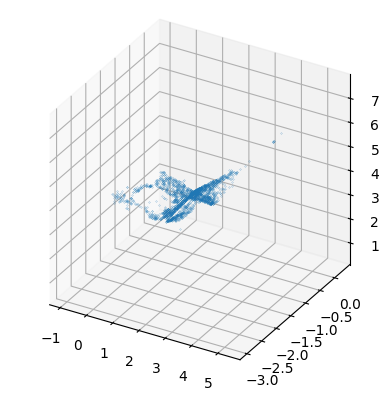

In [73]:
# Using the plotvol3() function, a three-dimensional space is created for visualization,
# and then all reconstructed 3D points P are plotted in this space as small points ('.'),
# allowing to visually assess the distribution and accuracy of scene geometry reconstruction.

plotvol3();
plt.plot(Pn[0,:], Pn[1,:], Pn[2,:], '.', markersize=0.3);


In [74]:
# Uncomment the lines below to visualize if PointCloud is installed
#walls_pcd = PointCloud(Pn)


In [75]:
# Uncomment the lines below to visualize
#walls_pcd.transform(SE3.Rx(pi))


In [76]:
# Uncomment the lines below to visualize
#walls_pcd.disp(block=True)


In [77]:
# Uncomment the lines below to visualize
#colors = []
#for m in matches:
#    colors.append(walls_l.image[int(m.p1[1]), int(m.p1[0]), :])
#pcd = SE3.Rx(pi) * PointCloud(Pn, colors=np.array(colors).T)
#pcd.disp(block=True)


In [78]:
# Uncomment the lines below to visualize
#walls_pcd = walls_pcd.remove_outlier(nb_points=10, radius=0.9) # Removing outliers from the point cloud using the remove_outlier method,
                          # which removes points for which in the specified radius (radius)
                          # there are fewer than the specified number of nearest points (nb_points).
                          # This helps clean the point cloud from noise and outlier points.


In [79]:
# Uncomment the lines below to visualize
#walls_pcd.disp(block=True) # Press H for control


In [80]:
#Красота на посмотреть раскомментировать строки ниже
#walls_pcd

In [81]:
Pn

array([[   1.167, -0.04174,    2.014, ...,   0.7929,   0.9322,   0.5926],
       [  -1.134,   -1.132,   -1.508, ...,   0.2741,   0.1345,   0.2164],
       [    2.59,    2.379,    3.436, ...,    1.297,    1.697,     1.46]])

In [82]:
# Save for logging and analysis if needed, just uncomment the line
#np.savetxt('my_array.txt', Pn, delimiter=',')


In [83]:
# Save for logging and analysis if needed, just uncomment the line
#np.savetxt('my_array.csv', Pn, delimiter=',')


In [84]:
# Prepare squares for capture
# You can work with them as with a log if computational power is not enough or parallelism is required


In [85]:
"""
# If we want to work with coordinate logs - we won't use it here
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt

#----------------"can be parallelized on different processors". ---------------------#

# Path to your CSV file
file_path = 'my_array.csv'  # Replace with your file path

# Reading data from the file
data = pd.read_csv(file_path, header=None)

# Transpose the DataFrame for convenience
points = data.T
points

#---------------"can be parallelized on different processors".---------------------#

#---------------- To avoid using additional libraries, we use our own rotation matrix -------------------#

# Rotation angle in radians (e.g., 90 degrees clockwise)
theta = np.pi / 2  # 90 degrees clockwise

# Rotation matrix around the X axis
rotation_matrix = np.array([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)]
])

# Rotate each point
# Apply the rotation matrix to each column (now row) of data
rotated_data = np.dot(points, rotation_matrix)
rotated_data

#----------------"can be parallelized on different processors". ---------------------#

# Convert the NumPy array to a DataFrame
df = pd.DataFrame(rotated_data)

# Specify the desired file name
new_file_path = 'pointsRx.csv'

# Save data to a new CSV file
df.to_csv(new_file_path, header=False, index=False)

# Display a success message
print(f'Data successfully saved to file {new_file_path}')

#----------------"can be parallelized on different processors". ---------------------#

# Transpose back if you need to preserve the original structure
# But we need it here
rotated_df = rotated_data.T

# Create a new DataFrame from the rotated data if you need to work with a DataFrame
rotated_df = pd.DataFrame(rotated_df, index=data.index, columns=data.columns)

# Display the first few columns of the rotated data for verification
print(rotated_df.head())
"""

'\n# If we want to work with coordinate logs - we won\'t use it here\n#import pandas as pd\n#import numpy as np\n#import matplotlib.pyplot as plt\n\n#----------------"can be parallelized on different processors". ---------------------#\n\n# Path to your CSV file\nfile_path = \'my_array.csv\'  # Replace with your file path\n\n# Reading data from the file\ndata = pd.read_csv(file_path, header=None)\n\n# Transpose the DataFrame for convenience\npoints = data.T\npoints\n\n#---------------"can be parallelized on different processors".---------------------#\n\n#---------------- To avoid using additional libraries, we use our own rotation matrix -------------------#\n\n# Rotation angle in radians (e.g., 90 degrees clockwise)\ntheta = np.pi / 2  # 90 degrees clockwise\n\n# Rotation matrix around the X axis\nrotation_matrix = np.array([\n    [1, 0, 0],\n    [0, np.cos(theta), -np.sin(theta)],\n    [0, np.sin(theta), np.cos(theta)]\n])\n\n# Rotate each point\n# Apply the rotation matrix to each 

In [86]:
# Just print for control
Pn


array([[   1.167, -0.04174,    2.014, ...,   0.7929,   0.9322,   0.5926],
       [  -1.134,   -1.132,   -1.508, ...,   0.2741,   0.1345,   0.2164],
       [    2.59,    2.379,    3.436, ...,    1.297,    1.697,     1.46]])

In [87]:
# Here we will simply transpose Pn without using additional libraries or unnecessary files
# Transpose
points = Pn.T
points


array([[   1.167,   -1.134,     2.59],
       [-0.04174,   -1.132,    2.379],
       [   2.014,   -1.508,    3.436],
       ...,
       [  0.7929,   0.2741,    1.297],
       [  0.9322,   0.1345,    1.697],
       [  0.5926,   0.2164,     1.46]])

In [88]:
# Rotate
# Angle of rotation in radians (e.g., 90 degrees clockwise)
theta = np.pi / 2  # 90 degrees clockwise
# Rotation matrix around the X axis
rotation_matrix = np.array([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)]
])

# Rotate each point
# Apply the rotation matrix to each column (now row) of the data
rotated_data = np.dot(points, rotation_matrix)
rotated_data


array([[   1.167,     2.59,    1.134],
       [-0.04174,    2.379,    1.132],
       [   2.014,    3.436,    1.508],
       ...,
       [  0.7929,    1.297,  -0.2741],
       [  0.9322,    1.697,  -0.1345],
       [  0.5926,     1.46,  -0.2164]])

In [89]:
# Split into squares for the frontal wall to pass as an array of points for our future controller
# Just math without clustering and AI. Since the distance between the cameras is 0.3, let the squares be 0.2

In [90]:
import pandas as pd

points_df = pd.DataFrame(rotated_data)

# Define the minimum and maximum values for Y and Z
min_y, max_y = points_df[1].min(), points_df[1].max()
min_z, max_z = points_df[2].min(), points_df[2].max()

# Define the number of squares along each axis
num_squares_y = int((max_y - min_y) / 0.2) + 1
num_squares_z = int((max_z - min_z) / 0.2) + 1

# Initialize a list to store information about all small squares
all_squares_info = []
# Initialize a dictionary to store points in each square
squares = {}

# Classify points into squares
for index, row in points_df.iterrows():
    y, z = row[1], row[2]
    square_y = int((y - min_y) / 0.2)
    square_z = int((z - min_z) / 0.2)
    square_key = (square_y, square_z)

    if square_key not in squares:
        squares[square_key] = []
    squares[square_key].append((y, z))

# Number of squares with at least one point
len(squares)


114

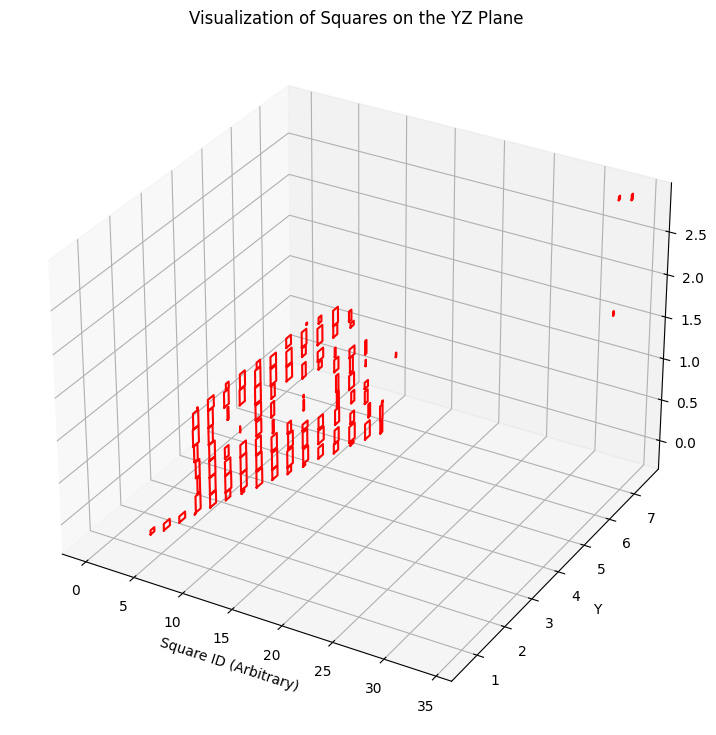

In [91]:
# Data preparation for 3D visualization of squares on the YZ plane
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Visualize each square
for square_key, points in squares.items():
    y_values, z_values = zip(*points)
    y_min, y_max = min(y_values), max(y_values)
    z_min, z_max = min(z_values), max(z_values)

    # Generate coordinates for drawing squares
    y_corners = [y_min, y_max, y_max, y_min, y_min]
    z_corners = [z_min, z_min, z_max, z_max, z_min]
    x_corners = [square_key[0]] * 5  # Use the square ID as the X coordinate for visualization

    # Draw the square
    ax.plot(x_corners, y_corners, z_corners, 'r-')

# Customize axis labels
ax.set_xlabel('Square ID (Arbitrary)')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Visualization of Squares on the YZ Plane')

plt.show()


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

points_df = pd.DataFrame(rotated_data)

# Determine the minimum and maximum values for Y and Z
min_y, max_y = points_df[1].min(), points_df[1].max()
min_z, max_z = points_df[2].min(), points_df[2].max()

# Determine the number of small squares along each axis for a size of 10x10 cm
num_small_squares_y = int((max_y - min_y) / 0.2) + 1
num_small_squares_z = int((max_z - min_z) / 0.2) + 1

# Initialize a list to store information about all small squares
all_squares_info = []

# Generate small squares and their coordinates
for y_idx in range(num_small_squares_y):
    for z_idx in range(num_small_squares_z):
        y_center = min_y + (y_idx * 0.2) + 0.05
        z_center = min_z + (z_idx * 0.2) + 0.05
        vertices = np.array([
            [-0.05, -0.05,  0.05,  0.05],  # X coordinates
            [y_center - 0.05, y_center + 0.05, y_center + 0.05, y_center - 0.05],  # Y coordinates
            [z_center - 0.05, z_center - 0.05, z_center + 0.05, z_center + 0.05]   # Z coordinates
        ])
        square_id = (y_idx, z_idx)
        all_squares_info.append((vertices, square_id))

# Initialize a structure to store points in squares
points_in_squares = {idx: [] for idx, _ in enumerate(all_squares_info)}

# Classify points into squares
for index, row in points_df.iterrows():
    y, z = row[1], row[2]
    square_y = int((y - min_y) / 0.2)
    square_z = int((z - min_z) / 0.2)
    square_index = square_y * num_small_squares_z + square_z
    points_in_squares[square_index].append((y, z))

# Output information only about squares with points
for idx, points in points_in_squares.items():
    if points:  # Check if there are points in the square
        print(f"Square {idx}")
        print("Points in the square:", points)
        # Get the coordinates of the square vertices from the all_squares_info list
        vertices, _ = all_squares_info[idx]
        print("The desired points P for our controller:")
        print("Coordinates of the square vertices:", vertices)
        print()


Square 2
Points in the square: [(0.6059641216867511, 0.23774632944483293)]
The desired points P for our controller:
Coordinates of the square vertices: [[   -0.05    -0.05     0.05     0.05]
 [   0.606    0.706    0.706    0.606]
 [  0.1158   0.1158   0.2158   0.2158]]

Square 51
Points in the square: [(1.3411541970591114, -0.2610400772009217), (1.340349308769352, -0.2606828168382642), (1.3332930769589286, -0.260895854837221), (1.3899533504568613, -0.24450472780921512), (1.3209652603336253, -0.27061152702389707), (1.393748622778402, -0.24091273408402586), (1.2789287600730699, -0.2824154046573769), (1.3946113588136946, -0.23671789310197602), (1.3411541970591114, -0.2610400772009217), (1.2876024206713224, -0.2820129494779823), (1.3919649295669472, -0.25163399472352993), (1.3952316632453352, -0.23771001730789834), (1.3834694932032705, -0.24721903323168587), (1.3370152599683247, -0.26605777005543135), (1.3812411241680855, -0.24260444328407826), (1.3670353354416858, -0.2537642577575395), (1

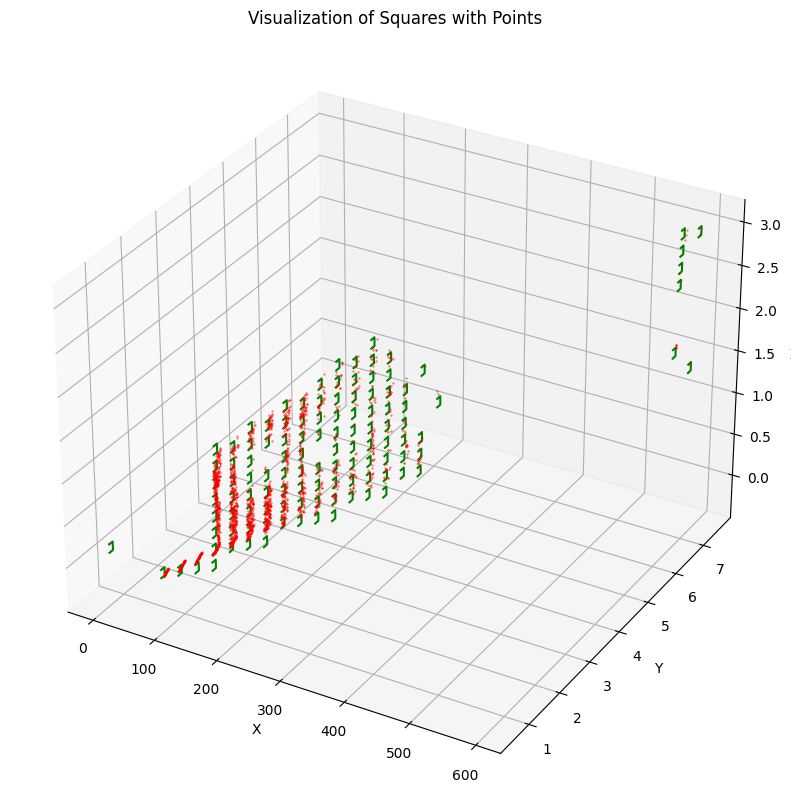

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Visualize squares and points in them
for idx, points in points_in_squares.items():
    if points:  # Visualize only squares containing points
        vertices, _ = all_squares_info[idx]

        # Coordinates for visualizing the square
        y_vertices, z_vertices = vertices[1], vertices[2]
        x_vertices = np.full_like(y_vertices, idx)  # Use idx as the X coordinate for uniqueness

        # Visualize the square
        ax.plot(x_vertices, y_vertices, z_vertices, 'g-')

        # Visualize points
        for y, z in points:
            ax.scatter([idx], [y], [z], color='r', s=0.1)

# Set axes labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Visualization of Squares with Points')

plt.show()
